In [34]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('Resources/epl_odds.csv')



In [36]:
# Calculate the average home probability across all bookmakers
df['Avg_Home_Prob'] = 1 / df.filter(like='Home_Odds_').mean(axis=1)

# Calculate the average draw probability across all bookmakers
df['Avg_Draw_Prob'] = 1 / df.filter(like='Draw_Odds_').mean(axis=1)

# Calculate the average away probability across all bookmakers
df['Avg_Away_Prob'] = 1 / df.filter(like='Away_Odds_').mean(axis=1)

# Calculate total probability (home + draw + away)
df['Total_Prob'] = df['Avg_Home_Prob'] + df['Avg_Draw_Prob'] + df['Avg_Away_Prob']

# Calculate arbitrage opportunity (True if Total_Prob < 1)
df['Arbitrage_Opportunity'] = df['Total_Prob'] < 1

# Display the first few rows to verify
df[['Avg_Home_Prob', 'Avg_Draw_Prob', 'Avg_Away_Prob', 'Total_Prob', 'Arbitrage_Opportunity']].head()

,Avg_Home_Prob,Avg_Draw_Prob,Avg_Away_Prob,Total_Prob,Arbitrage_Opportunity
0,0.602410,0.233345,0.224240,1.059995,False
1,0.524292,0.236761,0.188798,0.949851,True
2,0.495622,0.232378,0.193025,0.921025,True
3,0.540151,0.236407,0.192369,0.968927,True
4,0.110831,0.173699,0.772612,1.057143,False


In [37]:
df.head()

,Match_ID,Home_Team,Away_Team,Commence_Time,Away_Odds_1xBet,Away_Odds_888sport,Away_Odds_Bet Victor,Away_Odds_BetOnline.ag,Away_Odds_Betclic,Away_Odds_Betfair,...,Home_Odds_Suprabets,Home_Odds_Tipico,Home_Odds_Unibet,Home_Odds_Virgin Bet,Home_Odds_William Hill,Avg_Home_Prob,Avg_Draw_Prob,Avg_Away_Prob,Total_Prob,Arbitrage_Opportunity
0,00351878709543ad15bbba4b7a2062a1,Liverpool,Chelsea,2024-10-20T15:30:00Z,4.47,4.50,4.33,4.35,4.12,5.00,...,1.73,1.65,1.68,1.58,1.70,0.602410,0.233345,0.224240,1.059995,False
1,00f07d17652140a496750eb183ad1409,Chelsea,Newcastle United,2024-10-20T15:00:00Z,4.83,5.27,5.70,6.11,4.78,4.45,...,1.97,1.51,2.31,2.10,1.75,0.524292,0.236761,0.188798,0.949851,True
2,0264968cec144da3b8b99c156046cdff,Brighton & Hove Albion,Aston Villa,2024-10-20T15:00:00Z,6.38,5.97,5.43,4.16,6.12,4.19,...,1.44,1.56,2.00,1.95,1.95,0.495622,0.232378,0.193025,0.921025,True
3,0613fb74c36c472ca4133d0c79a08ee6,Manchester City,Everton,2024-10-20T15:00:00Z,5.31,4.02,4.23,6.11,4.57,5.89,...,1.87,1.49,2.03,1.42,1.82,0.540151,0.236407,0.192369,0.968927,True
4,08a9e3241c27d9fbb3aa3f1950527c63,Wolverhampton Wanderers,Manchester City,2024-10-20T13:00:00Z,1.32,1.29,1.29,1.30,1.26,1.34,...,9.70,9.00,9.00,8.50,9.50,0.110831,0.173699,0.772612,1.057143,False


<Figure size 1000x600 with 0 Axes>

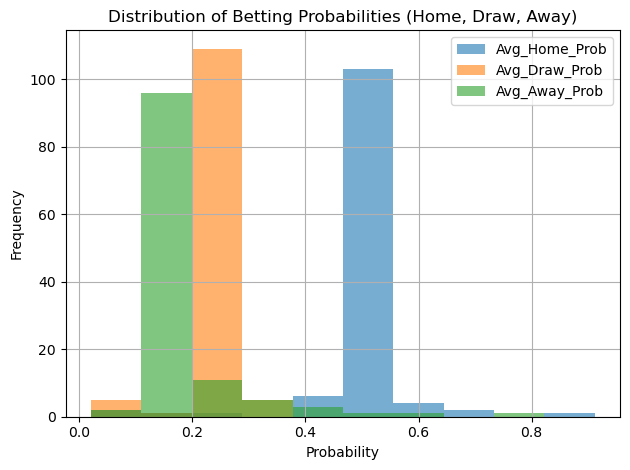

In [38]:
plt.figure(figsize=(10, 6))
df[['Avg_Home_Prob', 'Avg_Draw_Prob', 'Avg_Away_Prob']].plot(kind='hist', bins=10, alpha=0.6)
plt.title('Distribution of Betting Probabilities (Home, Draw, Away)')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

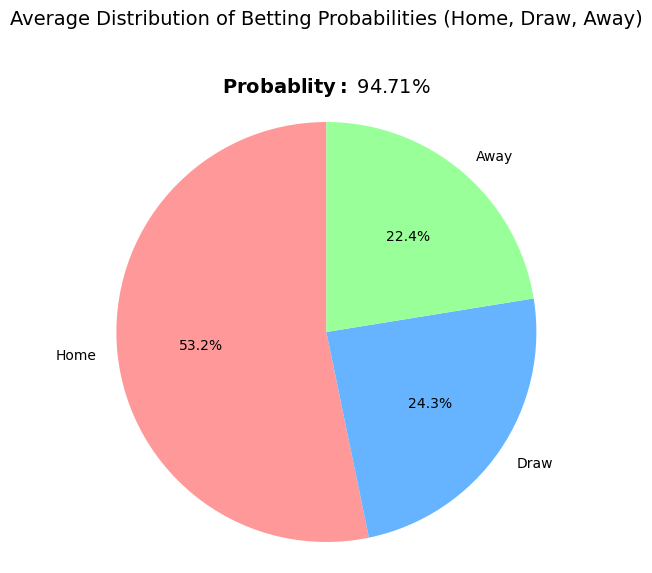

In [62]:
avg_probs = df[['Avg_Home_Prob', 'Avg_Draw_Prob', 'Avg_Away_Prob']].mean()
total_avg_prob = avg_probs.sum()

# Create a pie chart and show the total in the title
plt.figure(figsize=(8, 6))
plt.pie(avg_probs, labels=['Home', 'Draw', 'Away'], autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title(f'Average Distribution of Betting Probabilities (Home, Draw, Away)\n\n\n'
          + r'$\bf{Probablity:}$' + f' {total_avg_prob * 100:.2f}%', fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

In [39]:
# Step 1: Define features (X) and target (y)
X = df[['Avg_Home_Prob', 'Avg_Draw_Prob', 'Avg_Away_Prob']]
y = df['Arbitrage_Opportunity']

# Step 2: Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train models

# 3.1 XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Step 4: Evaluate models

# XGBoost evaluation
print("XGBoost Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print(classification_report(y_test, y_pred_xgb))

# Save the trained model to a pickle file
with open('arbitrage_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

print("Model saved as 'arbitrage_model.pkl'")


XGBoost Results:
Accuracy: 0.9583333333333334
              precision    recall  f1-score   support

       False       1.00      0.80      0.89         5
        True       0.95      1.00      0.97        19

    accuracy                           0.96        24
   macro avg       0.97      0.90      0.93        24
weighted avg       0.96      0.96      0.96        24

Model saved as 'arbitrage_model.pkl'


c:\Users\rdesh\anaconda3\envs\dev\lib\site-packages\xgboost\core.py:158: UserWarning: [20:18:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [63]:
y

0      False
1       True
2       True
3       True
4      False
       ...  
115     True
116     True
117     True
118     True
119     True
Name: Arbitrage_Opportunity, Length: 120, dtype: bool

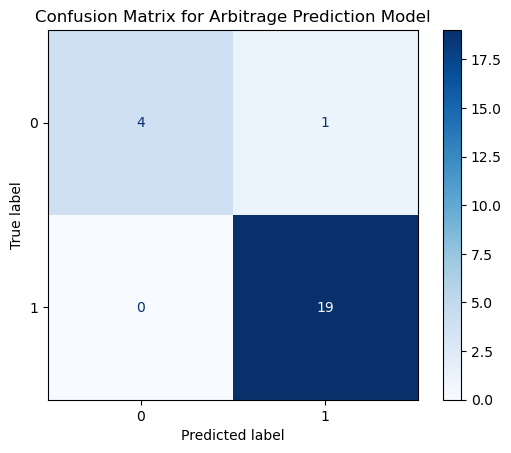

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Arbitrage Prediction Model')
plt.show()